## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import datetime
import json

## Open files

In [3]:
# Add income of UA budget
with open('data/budget_income.json') as b:
    budget_income_dict = json.loads(b.read())
    
# Add expenses of UA budget
with open('data/budget_expenses.json') as b_e:
    budget_expenses_dict = json.loads(b_e.read())
    
# Add consumer price index
with open('data/inflation.json', 'r') as inf:
    inflation_dict = json.loads(inf.read())
    
# Add incomes of all Ukrainian banks, except of NBU
with open('data/bank_inc.json', 'r') as bank_inc:
    bank_income_dict = json.loads(bank_inc.read())

# Add expenses of all Ukrainian banks, except of NBU
with open('data/bank_exp.json', 'r') as bank_exp:
    bank_expenses_dict = json.loads(bank_exp.read())
    
# Add amount of Ukrainian export
with open('data/export.json', 'r') as export:
    ua_export_dict = json.loads(export.read())
    
# Add amount of Ukrainian import
with open('data/import.json', 'r') as ua_imp:
    ua_import_dict = json.loads(ua_imp.read())
    
# Add gross external debt
with open('data/grossextdebt.json', 'r') as debt:
    grossextdebt_dict = json.loads(debt.read())

# Add Ukrainian GDP
with open('data/vvp.json', 'r') as gdp:
    gross_domestic_product_dict = json.loads(gdp.read())

# Add trends of exchange interest
df_interest_trend = pd.read_csv('data/kurs.csv')

# Add exchange rate UAH to USD
exchange_rate = pd.read_csv('data/exchange_rate.csv')

## Define a function to clean data from useless information

In [4]:
def df_cleaner(new_dict):
    
    # We need only these three columns
    new_cols = ['freq', 'value', 'date']
    df = pd.DataFrame(new_dict)
    
    #  A condition to choose only absolute values of import/export
    if df['tzep'][0] == 'F_':
        df = df.where(df['tzep'] == 'F_')
     
    # Rename columns
    df.rename(columns={'dt' : 'date'}, inplace = True)
    #df.rename(columns={'value' : df['txt'][0]})
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    
    # Throw away useless columns
    for col in list(df.columns.values):
        if col not in new_cols:
            df = df.drop(col, axis=1)
    
    # Return clean data
    return df


## Define function to leave only data of chosen frequency

In [5]:
def to_frequency(dataframe, frequency = 'M'):
    dataframe = dataframe.where(dataframe['freq'] == frequency)
    dataframe = dataframe.dropna(axis=0, how='all')
    dataframe.index = range(len(dataframe))
    return dataframe

# Preprocessing
## Clean and regroup the data about inflation in Ukraine

In [6]:
# Special function to 
def select_total(dictionary):
    df = pd.DataFrame(dictionary)
    
    # 'ku' - for region of Ukraine. I choose 'ku' == None and change it 
    # to the value 100500, which is out of range of Ukrainian regions.
    # 'tzep' - for absolute values.
    df.fillna(value='100500', inplace=True)
    df = df.where(df['ku'] == '100500')
    df = df.where(df['tzep'] == 'DTPY_')  
    
    # Rename columns
    df.rename(columns={'dt' : 'date'}, inplace = True)
    df.rename(columns={'value' : df['txten'][0]})
    
    # Convert date column to datetime type and sort data by date
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df = df.where(df['mcrd081'] == 'Total').dropna(axis=0, how='all')
    
    # Delete all the useless information
    new_cols = ['freq', 'value', 'date']
    for col in list(df.columns.values):
        if col not in new_cols:
            df = df.drop(col, axis=1)
                         
    # Return 
    return df

##  Define the dataset

In [7]:
# Define dataset
df_budget_income = to_frequency(df_cleaner(budget_income_dict), 'M')

df_budget_expenses = to_frequency(df_cleaner(budget_expenses_dict), 'M')

df_bank_income = to_frequency(df_cleaner(bank_income_dict), 'M')

df_bank_expenses = to_frequency(df_cleaner(bank_expenses_dict), 'M')

df_import = to_frequency(df_cleaner(ua_import_dict), 'Q') # pd.DataFrame(ua_import_dict) 
                          
df_export = to_frequency(df_cleaner(ua_export_dict), 'Q') # pd.DataFrame(ua_export_dict)
                         
df_grossextdebt = to_frequency(df_cleaner(grossextdebt_dict), 'Q')
                         
df_gdp = to_frequency(df_cleaner(gross_domestic_product_dict), 'Q') # pd.DataFrame(gross_domestic_product_dict)

df_inflation = to_frequency(select_total(inflation_dict), 'M') #pd.DataFrame(inflation_dict) 

#df_interest_trend = df_interest_trend.rename(columns={'Month' : 'date', 'курс валют: (Ukraine)' : 'interest trend'})

gdp_2017 = pd.read_csv('data/UkraineGDP.csv')

## Create new pandas dataframe to collect all the data

In [8]:
df_total = exchange_rate.copy()

#### Set date as an index

In [9]:
df_total['date'] = pd.to_datetime(df_total['date'])
df_total = df_total.set_index('date')

#### Cut off data for 1998-2009

In [10]:
df_total = df_total.loc[datetime.datetime(2010,1,1):datetime.datetime.now()]

### 1. Gross domestic product

#### Set date as index

In [11]:
gdp_2017['freq'] = 'Q'
gdp_2017['date'] = pd.to_datetime(gdp_2017['date'])
gdp_2017 = gdp_2017.set_index('date')
df_gdp = df_gdp.set_index('date')

I did't have enough data about Ukrainian GDP, so I make an assumption, that GDP growth in 2018 (comparing with 2017) is 3.1%. In fact, the value 3.1% was taken here
https://news.finance.ua/ua/news/-/417573/vvp-ukrayiny-prognozy-na-2018
The same issue had been concerning the quartal data for the beginning of 2010, so I've taken value for 2011 and substracted the growth of GDP in 2010.

In [12]:
df_gdp = df_gdp.append(gdp_2017[1:])
df_gdp.loc[datetime.datetime(2010,1,1)] = ['Q', df_gdp['value'][datetime.datetime(2010,4,1)] * (1-0.042)]
df_gdp.loc[datetime.datetime(2018,1,1)] = ['Q', gdp_2017['value'][datetime.datetime(2017,1,1)] * 1.034]
df_gdp.loc[datetime.datetime(2018,4,1)] = ['Q', gdp_2017['value'][datetime.datetime(2017,4,1)] * 1.034]
df_gdp = df_gdp.sort_index()

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


#### Change frequency of GDP to daily, missing values are replaced with interpolated

In [13]:
df_gdp = df_gdp.asfreq('D')

In [14]:
df_gdp = df_gdp.apply(pd.Series.interpolate)

### 2. Inflation

#### Look through data

In [15]:
df_inflation[-8:]

,date,freq,value
125,2017-07-01,M,7.9
126,2017-08-01,M,8.2
127,2017-09-01,M,8.1
128,2017-10-01,M,10.2
129,2017-11-01,M,11.5
130,2017-12-01,M,12.5
131,2018-01-01,M,13.7
132,2018-02-01,M,1.5


####  Set date as index

In [16]:
df_inflation['date'] = pd.to_datetime(df_inflation['date'])
df_inflation = df_inflation.set_index('date')

#### Prices' growth during last 8 years

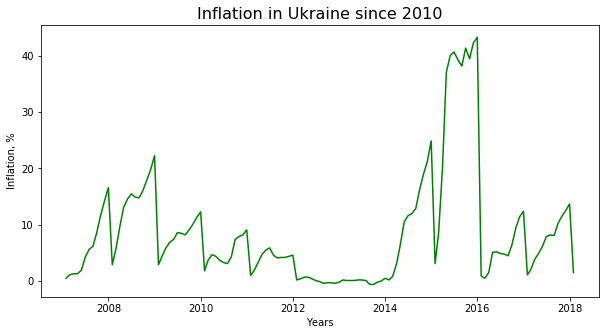

In [17]:
plt.figure(figsize=[10,5])
plt.plot(df_inflation['value'], color='g')
plt.title('Inflation in Ukraine since 2010', fontsize='16')
plt.xlabel('Years')
plt.ylabel('Inflation, %')
plt.show()

#### Another assumption, based on information from this link https://index.minfin.com.ua/economy/index/inflation/

I suppose, that inflation in March 2018 changed by 2.4%, which is mean value for two previous months.

In [18]:
df_inflation = df_inflation.loc['20100101':datetime.date.today()]
hypothethic_inflation = ['Q', df_inflation['value'][datetime.datetime(2018,2,1)] * 1.024]
df_inflation.loc[datetime.datetime(2018,4,1)] = hypothethic_inflation

#### Daily frequency is required

In [19]:
df_inflation = df_inflation.asfreq('D')
df_inflation = df_inflation.apply(pd.Series.interpolate)

### 3. Exports

#### As usual, use date instead of numerical index

In [20]:
df_export['date'] = pd.to_datetime(df_export['date'])
df_export = df_export.set_index('date')

#### Figure out boundary values

I took information about exports and imports in the fourth quarter from this document:
https://bank.gov.ua/doccatalog/document?id=25173322
Despite it was uploaded to the NBU website, this information hadn't been uploaded to the NBU API webpage, so I have had to input it manually.
One more hypothesis is, that such old data like exports in the first quarter of 2010 doesn't play a big role in the forecast, so I've decided to use the duplicate the initial data for the preceding period.

In [21]:
hypothethic_export = ['Q', df_export['value'][0]]
df_export.loc[datetime.datetime(2010,1,1)] = hypothethic_export
hypothethic_export = ['Q', df_export['value'][datetime.datetime(2017,1,1)] * 1.183]
df_export.loc[datetime.datetime(2018,4,1)] = hypothethic_export
df_export = df_export.sort_index()

#### Set frequency to daily and use interpolation to fill missing values

In [22]:
df_export = df_export.asfreq('D')
df_export = df_export.apply(pd.Series.interpolate)

### 4. Imports

#### Set data as index

In [23]:
df_import['date'] = pd.to_datetime(df_import['date'])
df_import = df_import.set_index('date')

#### The same hypothesis, as for exports

In [24]:
df_import.loc[datetime.datetime(2010,1,1)] = ['Q', df_import['value'][0]]

hypothethic_import = ['Q', df_import['value'][datetime.datetime(2017,1,1)] * 1.211]
df_import.loc[datetime.datetime(2018,4,1)] = hypothethic_import

df_import = df_import.sort_index()

#### Resign values, change frequency to daily and replace 'nan's with interpolated data

 Interesting fact: all recorded imports data in the NBU API have negetive sign. 

In [25]:
df_import['value'] = - df_import['value']

In [26]:
df_import = df_import.asfreq('D')
df_import = df_import.apply(pd.Series.interpolate)

#### Trade balance plot

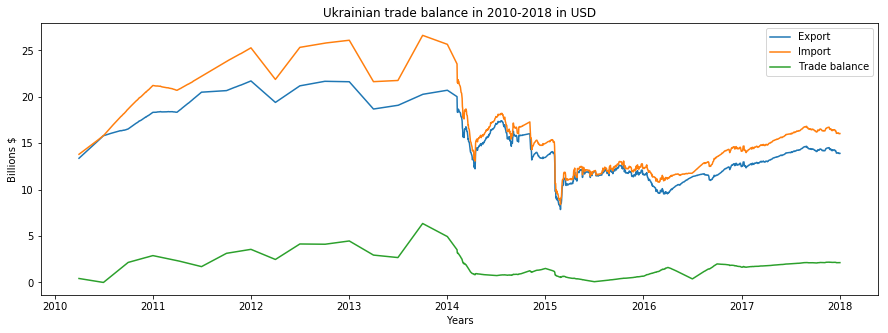

In [27]:
plt.figure(figsize=[15,5])

plt.plot((df_export['value'].loc['20100401':'20180101']).divide(df_total['exchange rate'].loc['20100401':'20180101']) / 1000)
plt.plot((df_import['value'].loc['20100401':'20180101']).divide(df_total['exchange rate'].loc['20100401':'20180101']) / 1000)
plt.plot(((df_import['value'] - df_export['value']).loc['20100401':'20180101']).divide(df_total['exchange rate'].loc['20100401':'20180101']) / 1000)

plt.legend(['Export','Import', 'Trade balance'])
plt.title('Ukrainian trade balance in 2010-2018 in USD')
plt.xlabel('Years')
plt.ylabel('Billions $')
plt.show()

### 4. Gross Extended Debt

#### Replace numerical index with date

In [28]:
df_grossextdebt['date'] = pd.to_datetime(df_grossextdebt['date'])
df_grossextdebt = df_grossextdebt.set_index('date')

#### Information taken manually here https://bank.gov.ua/doccatalog/document?id=36693528, also it hadn't been added to the API.

In [29]:
df_grossextdebt.loc[datetime.datetime(2018,1,1)] = ['Q', 116578.0]
t = 2 * df_grossextdebt['value'][datetime.datetime(2018,1,1)] - df_grossextdebt['value'][datetime.datetime(2017,10,1)]
df_grossextdebt.loc[datetime.datetime(2018,4,1)] = ['Q', t]

In [30]:
df_grossextdebt = df_grossextdebt.loc['20100101':datetime.datetime.now()]

#### Daily frequency 

In [31]:
df_grossextdebt = df_grossextdebt.asfreq('D')
df_grossextdebt = df_grossextdebt.apply(pd.Series.interpolate)

#### Change of Gross extended debt plot

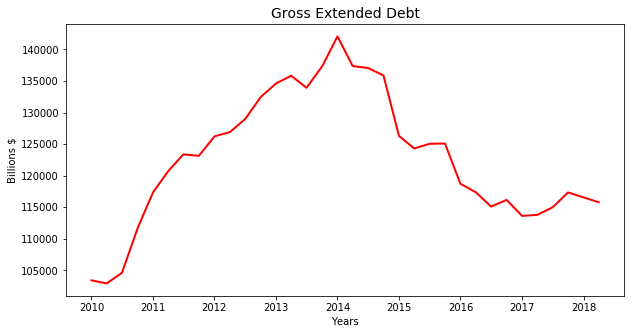

In [32]:
plt.figure(figsize=[10,5])
plt.plot(df_grossextdebt['value'], color='r', linewidth='2')
plt.title('Gross Extended Debt', fontsize='14')
plt.xlabel('Years')
plt.ylabel('Billions $')
plt.show()

### 5. Trend of interest

#### Interest trend has been taken from the Google Trends (https://trends.google.com/trends/), topic: "_курс валют_".


In [36]:
df_interest_trend['date'] = pd.to_datetime(df_interest_trend['Month'])
df_interest_trend = df_interest_trend.set_index('date')

#### I delete next string of code after data for April appeared

In [39]:
df_interest_trend.loc[datetime.datetime(2018,4,1)] = df_interest_trend['курс валют: (Ukraine)'][datetime.datetime(2018,3,1)]

#### Slice the period, set daily frequency and replace missing data with interpolated.

In [40]:
df_interest_trend = df_interest_trend.loc['20100101':datetime.datetime.now()]

In [41]:
df_interest_trend = df_interest_trend.asfreq('D')
df_interest_trend = df_interest_trend.apply(pd.Series.interpolate)

In [48]:
df_interest_trend.drop(['Month'], axis=1, inplace=True)

In [59]:
df_interest_trend.columns = ['rate']

### Unite it all together

In [60]:
df_total['GDP'] = df_gdp['value']
df_total['Inflation'] = df_inflation['value']
df_total['Export'] = df_export['value']
df_total['Import'] = df_import['value']
df_total['GrossExtDebt'] = df_grossextdebt['value']
df_total['Interest Trend'] = df_interest_trend

#### Add extra feature, showing Ukrainian GDP in United States Dollars 

In [61]:
df_total['GDP in $'] = df_total['GDP'].divide(df_total['exchange rate'])

#### The difference between gross domestic product in USD (left plot) and UAH (right plot)

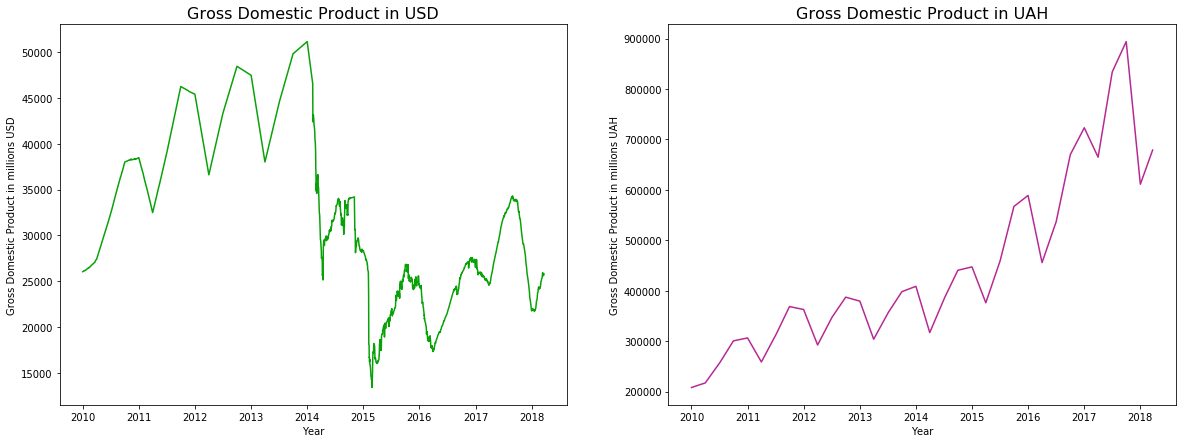

In [62]:
plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
plt.plot(df_total['GDP in $'], color='#08A208')
plt.title('Gross Domestic Product in USD', fontsize='16')
plt.xlabel('Year')
plt.ylabel("Gross Domestic Product in millions USD")
plt.subplot(1,2,2)
plt.title('Gross Domestic Product in UAH', fontsize='16')
plt.xlabel('Year')
plt.ylabel("Gross Domestic Product in millions UAH")
plt.plot(df_total['GDP'], color="#B72893")
plt.show()

##### Save data to CSV

In [64]:
df_total.to_csv('data/dataset.csv')

In [65]:
df_total

,exchange rate,GDP,Inflation,Export,Import,GrossExtDebt,Interest Trend,GDP in $
date,,,,,,,,
2010-01-01,7.985000,207956.892000,12.300000,106050.000000,109445.000000,103432.000000,26.000000,26043.442956
2010-01-02,7.985000,208058.193200,11.961290,106050.000000,109445.000000,103426.500000,25.903226,26056.129393
2010-01-03,7.985000,208159.494400,11.622581,106050.000000,109445.000000,103421.000000,25.806452,26068.815830
2010-01-04,7.985000,208260.795600,11.283871,106050.000000,109445.000000,103415.500000,25.709677,26081.502267
2010-01-05,7.985000,208362.096800,10.945161,106050.000000,109445.000000,103410.000000,25.612903,26094.188704
2010-01-06,7.985000,208463.398000,10.606452,106050.000000,109445.000000,103404.500000,25.516129,26106.875141
2010-01-07,7.985000,208564.699200,10.267742,106050.000000,109445.000000,103399.000000,25.419355,26119.561578
2010-01-08,7.985000,208666.000400,9.929032,106050.000000,109445.000000,103393.500000,25.322581,26132.248015
2010-01-09,7.985000,208767.301600,9.590323,106050.000000,109445.000000,103388.000000,25.225806,26144.934452
